In [1]:
%cd ..

%config InlineBackend.figure_format = "retina"

/home/marco/thesis_project/contrast-gan-3D


In [2]:
# TODO check that evaluated scans do not contain outliers that shift the whole distribution
# TODO redo after CCTAContrastCorrector cuda cache fix

In [10]:
from pathlib import Path
from pprint import pprint

from batchgenerators.utilities.file_and_folder_operations import load_pickle

from contrast_gan_3D.alias import ScanType
from contrast_gan_3D.config import ASSETS_DIR, CHECKPOINTS_DIR, DEFAULT_CVAL_SPLITS_PATH
from contrast_gan_3D.eval import utils as eval_u

# from contrast_gan_3D.experiments.conf_2D import train_patch_size as inference_patch_size
from contrast_gan_3D.experiments.small_patch_size import (
    train_patch_size as inference_patch_size,
)
from contrast_gan_3D.trainer.utils import divide_scans_in_fold
from contrast_gan_3D.utils import set_GPU

DEVICE = set_GPU(5)
RUN_ID = "r3jqsob7"
RUN_NAME = "3D-WC-small-rmsprop"
ITER_CHECKPOINT = 8000
# RUN_NAME = "2D-WC-baseline"
# RUN_ID = "g5gqrbqo"
# ITER_CHECKPOINT = 6000

model_checkpoint = CHECKPOINTS_DIR / RUN_ID / f"{ITER_CHECKPOINT}.pt"
print(model_checkpoint)
assert model_checkpoint.is_file()

splits = load_pickle(DEFAULT_CVAL_SPLITS_PATH)
# trained on first fold, so use first test fold for evaluation
train_fold, val_fold = splits["train"][0], splits["test"][0]
for p, l in val_fold:
    print(p, ScanType(l))
subopt_patients = [
    p for (p, l) in val_fold if (sl := ScanType(l)) in [ScanType.HIGH, ScanType.LOW]
]
print(len(subopt_patients))

savepath = ASSETS_DIR / "evaluation" / RUN_NAME
savepath.parent.mkdir(exist_ok=True, parents=True)

# NOTE set to None to avoid exporting corrected scans
ITK_EXPORT_DIR = Path.home() / "data" / "corrections" / RUN_NAME
ITK_EXPORT_DIR.mkdir(exist_ok=True, parents=True)

for t, l in splits.items():
    print(t)
    for i, d in enumerate(l):
        pprint({ScanType(k): len(v) for k, v in divide_scans_in_fold(d).items()})

/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/r3jqsob7/8000.pt
/home/marco/data/preproc/ASOCA_Philips/ASOCA-001 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-002 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-003 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-004 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-005 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-006 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-007 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-013 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-016 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-018 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-020 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-025 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-029 ScanType.LOW
/home/marco/data/preproc/ASOCA_Philips/ASOCA-031 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOC

In [ ]:
from contrast_gan_3D.experiments.small_patch_size import (
    train_patch_size as inference_patch_size,
)

RUN_ID = "r3jqsob7"
RUN_NAME = "3D-WC-small-rmsprop"
ITER_CHECKPOINT = 8000

model_ckpt = project.CHECKPOINTS_DIR / RUN_ID / f"{ITER_CHECKPOINT}.pt"

In [ ]:
savedir = project.CORRECTIONS_DIR / RUN_NAME
savedir.mkdir(exist_ok=True, parents=True)

all_eval_paths = [
    project.PREPROC_DATA_DIR / f"IDR_CADRADS/{name}" for name in labels["ID"].values
]
correction_fnames = [
    (savedir / name).with_suffix(".mhd") for name in labels["ID"].values
]
eval_paths = [pp for pp, p in zip(all_eval_paths, correction_fnames) if not p.is_file()]
print(len(all_eval_paths), len(eval_paths))
print(correction_fnames[:3])

96 0
[PosixPath('/home/marco/data/corrections/3D-WC-small-rmsprop/3153.mhd'), PosixPath('/home/marco/data/corrections/3D-WC-small-rmsprop/3169.mhd'), PosixPath('/home/marco/data/corrections/3D-WC-small-rmsprop/3177.mhd')]


In [ ]:
DEVICE = set_GPU(7)

if len(eval_paths):
    corrector = CCTAContrastCorrector.from_checkpoint(
        inference_patch_size, DEVICE, model_ckpt
    )
    eval_u.parallel_correct_patients(corrector, savedir, eval_paths)

Loaded evaluation voxels from '/home/marco/thesis_project/contrast-gan-3D/assets/evaluation/3D-WC-small-rmsprop.pkl'
Scans distribution by label:
{<ScanType.OPT: 0>: 23, <ScanType.LOW: -1>: 3, <ScanType.HIGH: 1>: 14}
ScanType.OPT
	Total voxels 'centerlines': 87755
	Total voxels 'ostia': 46
	Total voxels 'myocardium': 20697612
ScanType.LOW
	Total voxels 'centerlines': 13337
	Total voxels 'ostia': 6
	Total voxels 'myocardium': 4733851
ScanType.HIGH
	Total voxels 'centerlines': 60186
	Total voxels 'ostia': 28
	Total voxels 'myocardium': 14300490


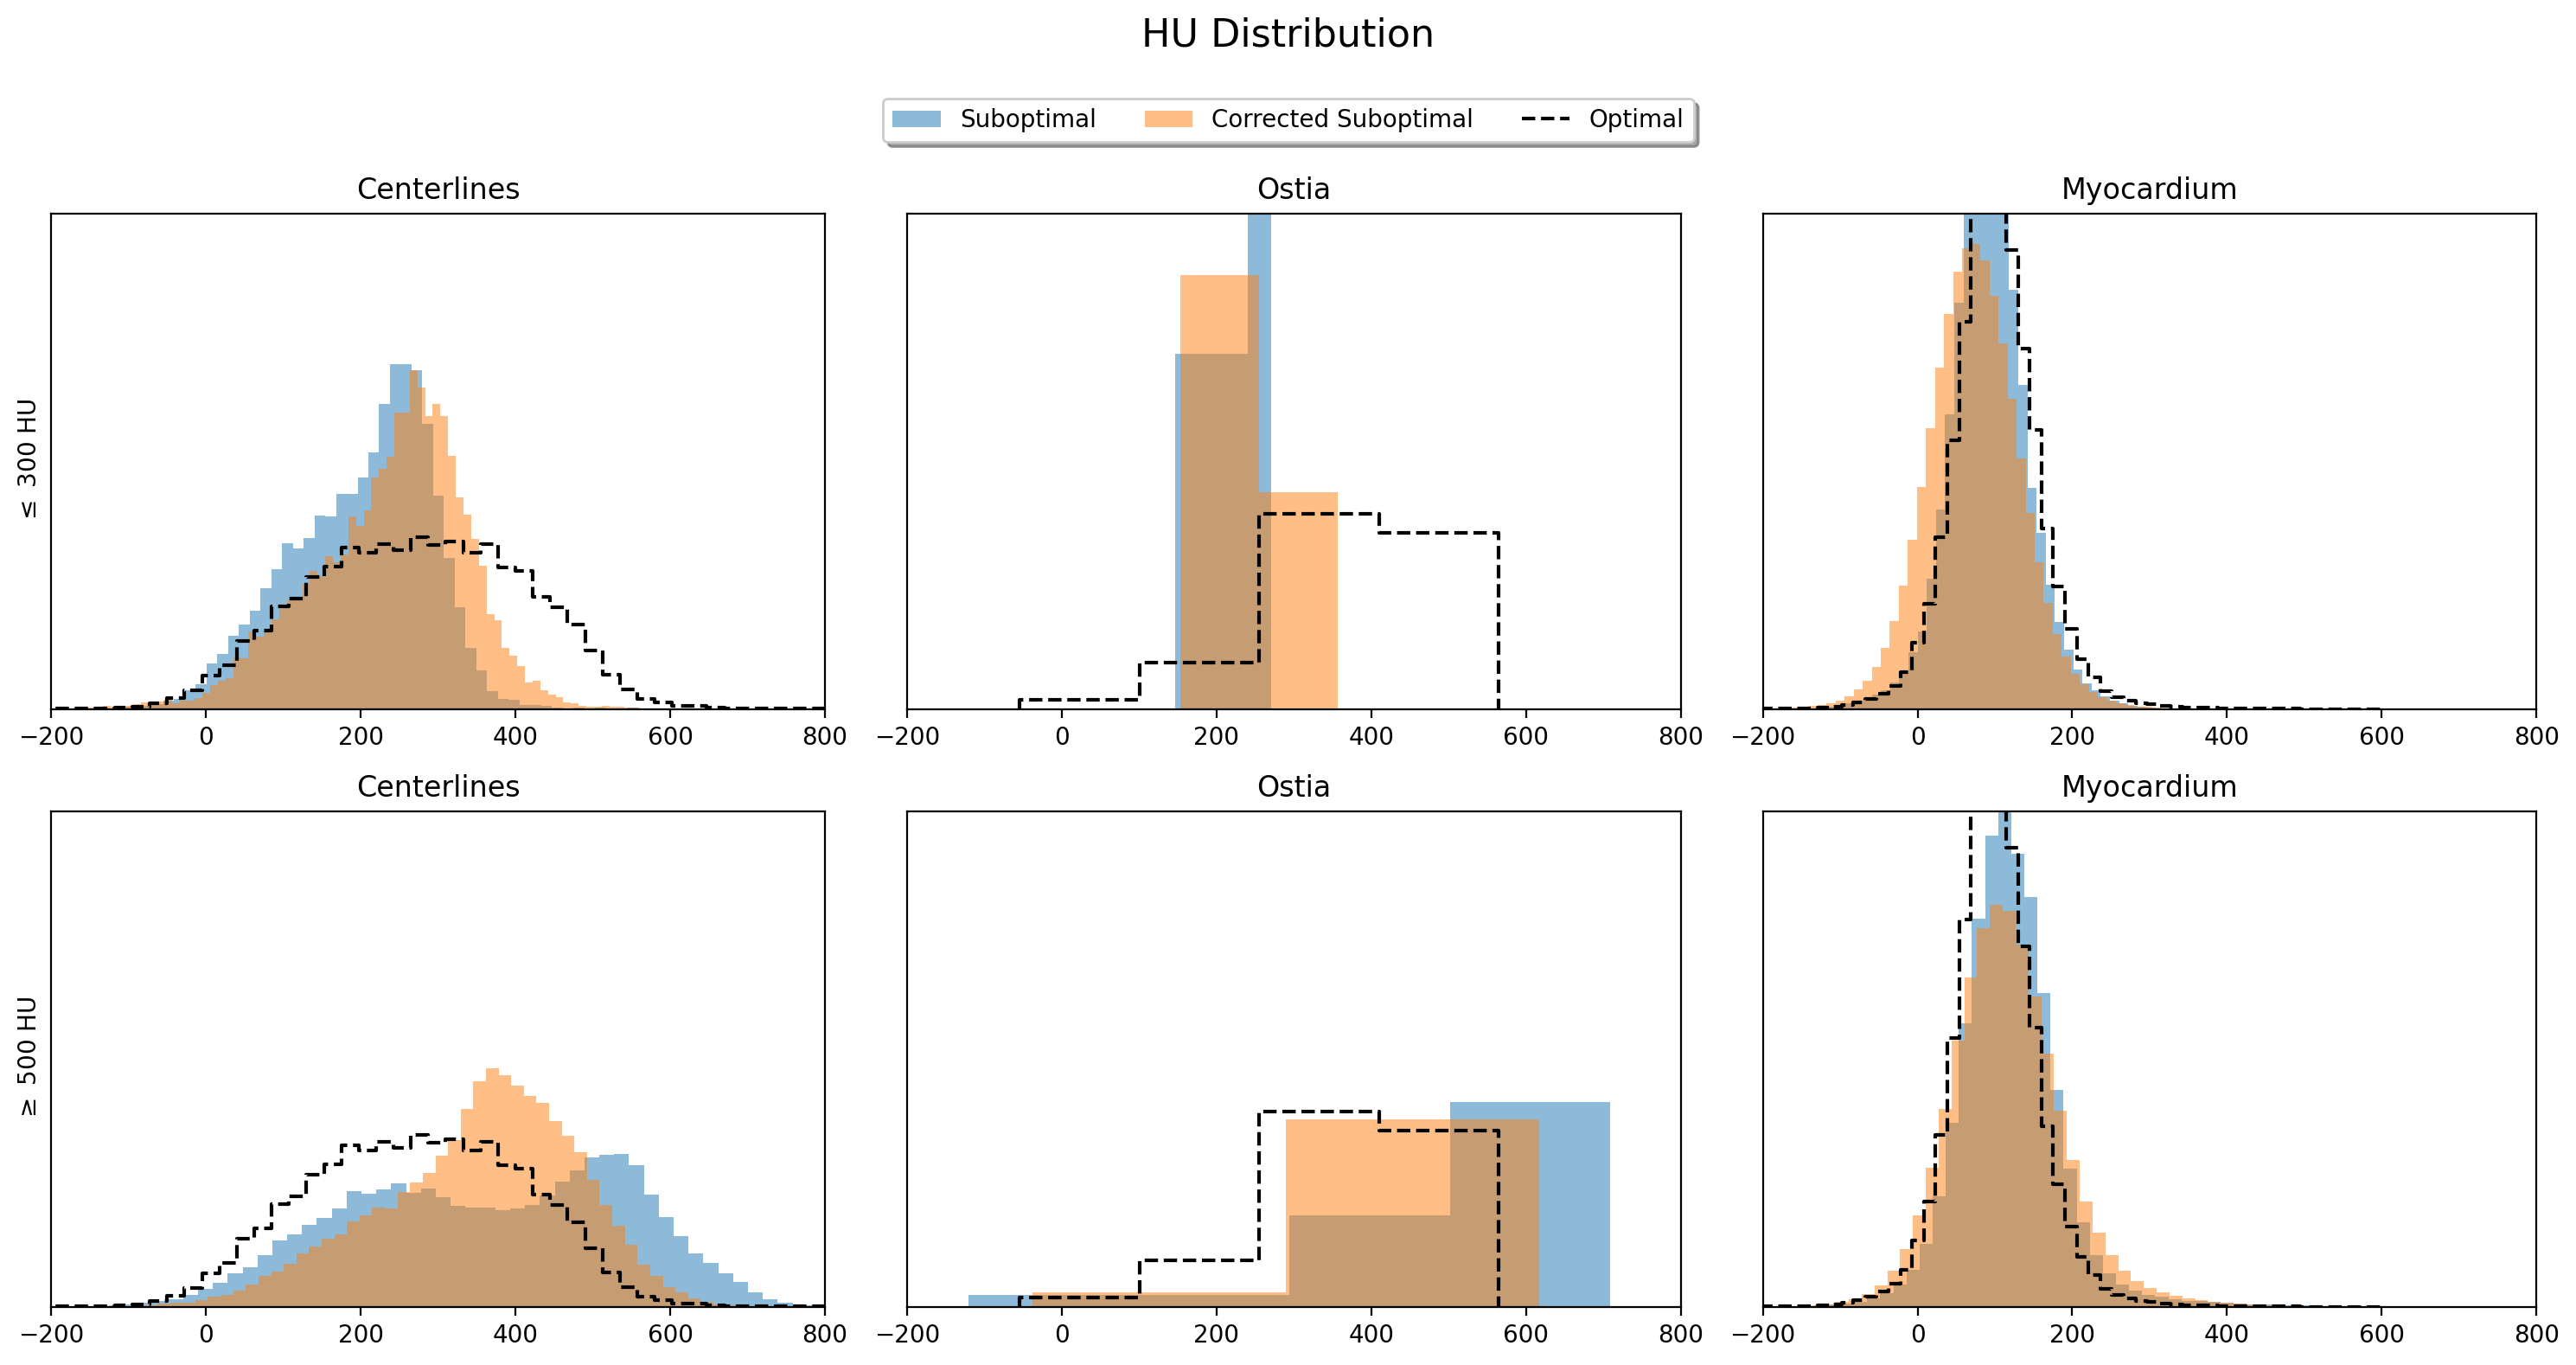

In [10]:
raw, corrected = eval_u.eval_HU_distribution_shift(
    model_checkpoint,
    val_fold,
    inference_patch_size,
    savepath,
    # savepath,
    None,
    DEVICE,
    # itk_export_dir=ITK_EXPORT_DIR,
)
contrast_gan_3D.evalHU_distribution_shift

In [ ]:
from contrast_gan_3D.data import utils as data_u
from contrast_gan_3D.eval.CCTAContrastCorrector import CCTAContrastCorrector
from contrast_gan_3D.trainer import utils as train_u
from contrast_gan_3D.trainer.logger.WandbLogger import WandbLogger

model_ids = ["fu610ldk", "r3jqsob7", "315g1ay1", "blwlllmf", "7dk1ofud"]
model_names = [
    "3D-WC-small-train-long",
    "3D-WC-small-rmsprop",
    "3D-WGAN-GP",
    "3D-baseline-gp-10k",
    "baseline-WC",
]
high_datapoint = "/home/marco/data/preproc/ASOCA_Philips/ASOCA-002"
low_datapoint = "/home/marco/data/preproc/ASOCA_Philips/ASOCA-029"

for model_id, model_name in zip(model_ids, model_names):
    print(model_name, model_id)

    ckpt_dir = CHECKPOINTS_DIR / model_id
    ckpt_iter = train_u.find_latest_checkpoint(ckpt_dir)
    ckpt = ckpt_dir / f"{ckpt_iter}.pt"
    print(ckpt)

    patch_size = (128, 128, 128)
    if "small" in model_name:
        patch_size = (128, 128, 32)

    corrector = CCTAContrastCorrector.from_checkpoint(
        patch_size, DEVICE, checkpoint_path=ckpt
    )

    for dp in [high_datapoint, low_datapoint]:
        scan, meta = data_u.load_patient(str(p))
        offset, spacing = meta["offset"], meta["spacing"]
        corrected_ccta = corrector(scan[..., 0], desc=str(dp))

        corrected = corrector(dp)



In [ ]:
from contrast_gan_3D.eval.CCTAContrastCorrector import CCTAContrastCorrector

corrector = CCTAContrastCorrector.from_checkpoint(
    inference_patch_size, DEVICE, checkpoint_path=model_checkpoint
)

In [ ]:
eval_u.correct_patients(corrector, subopt_patients, ITK_EXPORT_DIR)

[2024-06-28 12:59:58,228: INFO] Loaded model checkpoint '/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/r3jqsob7/8000.pt' (contrast_gan_3D.eval.CCTAContrastCorrector:58)


/home/marco/micromamba/envs/contrast-gan-3D/lib/python3.11/site-packages/patchly/array_like.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


/home/marco/data/preproc/ASOCA_Philips/ASOCA-002:   0%|          | 0/7 [00:00<?, ?it/s]

[2024-06-28 13:00:24,484: INFO] Saving scan to '/home/marco/data/corrections/3D-WC-small-rmsprop/ASOCA-002.mhd'... (contrast_gan_3D.utils.io_utils:126)
[2024-06-28 13:00:44,825: INFO] DONE (contrast_gan_3D.utils.io_utils:128)


/home/marco/data/preproc/ASOCA_Philips/ASOCA-003:   0%|          | 0/7 [00:00<?, ?it/s]

[2024-06-28 13:01:01,836: INFO] Saving scan to '/home/marco/data/corrections/3D-WC-small-rmsprop/ASOCA-003.mhd'... (contrast_gan_3D.utils.io_utils:126)
[2024-06-28 13:01:32,193: INFO] DONE (contrast_gan_3D.utils.io_utils:128)


/home/marco/data/preproc/ASOCA_Philips/ASOCA-004:   0%|          | 0/7 [00:00<?, ?it/s]

[2024-06-28 13:01:48,178: INFO] Saving scan to '/home/marco/data/corrections/3D-WC-small-rmsprop/ASOCA-004.mhd'... (contrast_gan_3D.utils.io_utils:126)
[2024-06-28 13:02:12,815: INFO] DONE (contrast_gan_3D.utils.io_utils:128)


/home/marco/data/preproc/ASOCA_Philips/ASOCA-006:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
from pprint import pprint
from contrast_gan_3D.alias import ScanType

for k, d in splits.items():
    print(k)
    for el in d:
        pprint({ScanType(k): len(v) for k, v in eval_u.divide_scans_in_fold(el).items()})

train
{<ScanType.LOW: -1>: 7, <ScanType.HIGH: 1>: 29, <ScanType.OPT: 0>: 44}
{<ScanType.LOW: -1>: 7, <ScanType.HIGH: 1>: 28, <ScanType.OPT: 0>: 45}
{<ScanType.LOW: -1>: 6, <ScanType.HIGH: 1>: 29, <ScanType.OPT: 0>: 45}
test
{<ScanType.LOW: -1>: 3, <ScanType.HIGH: 1>: 14, <ScanType.OPT: 0>: 23}
{<ScanType.LOW: -1>: 3, <ScanType.HIGH: 1>: 15, <ScanType.OPT: 0>: 22}
{<ScanType.LOW: -1>: 4, <ScanType.HIGH: 1>: 14, <ScanType.OPT: 0>: 22}


In [3]:
from pathlib import Path

import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import wandb
from contrast_gan_3D.alias import ScanType
from contrast_gan_3D.config import CHECKPOINTS_DIR, ROOT_DIR
from contrast_gan_3D.constants import VMAX, VMIN
from contrast_gan_3D.data import utils as data_u
from contrast_gan_3D.eval import utils as eval_u
from contrast_gan_3D.eval.CCTAContrastCorrector import CCTAContrastCorrector
from contrast_gan_3D.experiments.conf_2D import \
    generator_class as generator_class_2D
from contrast_gan_3D.experiments.gradient_penalty_conf import \
    generator_class as generator_class_3D
from contrast_gan_3D.experiments.gradient_penalty_conf import scaler
from contrast_gan_3D.experiments.gradient_penalty_conf import \
    train_patch_size as inference_patch_size_3D
from contrast_gan_3D.trainer.utils import divide_scans_in_fold
from contrast_gan_3D.utils import geometry as geom
from contrast_gan_3D.utils import io_utils, set_GPU
from contrast_gan_3D.utils import visualization as viz

[2024-06-27 11:46:43,146: INFO] Subtract 238 to 0-center scans (contrast_gan_3D.data.Scaler:28)


ImportError: cannot import name 'generator_class' from 'contrast_gan_3D.experiments.gradient_penalty_conf' (/home/marco/thesis_project/contrast-gan-3D/contrast_gan_3D/experiments/gradient_penalty_conf.py)

In [ ]:
DATASET_NAME = "ASOCA_Philips"

DATASET = Path("/home/marco/data/preproc") / DATASET_NAME

MASK_PATHS = Path("/home/marco/data/segmentations") / DATASET_NAME
MASK_PATHS = sorted(list(MASK_PATHS.glob("*.mhd")))

savefolder = Path("/home/marco/thesis_project/contrast-gan-3D/assets/myocardium_seg/")
savefolder.mkdir(exist_ok=True, parents=True)

if False:
    for mask_path in tqdm(MASK_PATHS):
        mask_name = io_utils.stem(mask_path)
        scan_path = DATASET / mask_name
        if mask_path.is_symlink():
            mask_path = mask_path.readlink()

        print(mask_path)
        seg, seg_meta = io_utils.load_sitk_image(mask_path, segmentation=True)
        scan, scan_meta = data_u.load_patient(scan_path)
        scan = scan[..., 0]
        # scan, scan_meta = io_utils.load_sitk_image("/home/marco/data/ASOCA_Philips/images/ASOCA-000.mhd")

        suffix = ""
        overlay = np.ma.masked_array(scan, seg)
        viz.plot_mid_slice(overlay)

        # NOTE runs slower but better visualization

        # suffix = "_all"
        # fig = viz.plot_axial_slices(
        #     scan[None, ..., ::7],
        #     value_range=(VMIN, VMAX),
        #     normalize=True,
        #     figsize=(15, 15),
        #     tight=False,
        # )
        # overlay = np.zeros((*scan.shape, 4))
        # overlay[seg == 1] = [1, 0, 0, 0.5]
        # overlay = overlay.transpose(3, 0, 1, 2)
        # viz.plot_axial_slices(overlay[..., ::7], fig=fig, tight=True)

        plt.tight_layout()
        plt.savefig(savefolder / f"{mask_name}{suffix}.png")
        plt.close()

In [ ]:
WANDB_ENTITY = "xqz-u"
WANDB_PROJECT = "contrast-gan-3D"

# RUN_ID_2D = "g5gqrbqo"
RUN_ID_2D = "sp3nukcr"
model_checkpoint_2D = CHECKPOINTS_DIR / RUN_ID_2D / "10000.pt"
print(model_checkpoint_2D, model_checkpoint_2D.is_file())

#53d-baseline-gp-10k
RUN_ID_3D = "blwlllmf"
model_checkpoint_3D = CHECKPOINTS_DIR / RUN_ID_3D / "7000.pt"
print(model_checkpoint_3D, model_checkpoint_3D.is_file())

DEVICE = set_GPU(5)

/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/sp3nukcr/10000.pt True
/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/blwlllmf/7000.pt True


In [ ]:
corrector_2D = CCTAContrastCorrector(
    generator_class_2D,
    scaler,
    DEVICE,
    checkpoint_path=model_checkpoint_2D,
)

[2024-06-03 17:42:01,908: INFO] Loaded model checkpoint '/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/sp3nukcr/10000.pt' (contrast_gan_3D.eval.CCTAContrastCorrector:57)


In [ ]:
corrector_3D = CCTAContrastCorrector(
    generator_class_3D,
    scaler,
    DEVICE,
    inference_patch_size=inference_patch_size_3D,
    checkpoint_path=model_checkpoint_3D,
)

[2024-06-03 17:42:03,808: INFO] Loaded model checkpoint '/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/blwlllmf/7000.pt' (contrast_gan_3D.eval.CCTAContrastCorrector:57)


In [ ]:
og_voxels, corrected_voxels_2D = eval_u.collect_evaluation_histograms(
    scan_and_myoc_paths, corrector_2D
)
torch.cuda.empty_cache()contrast_gan_3D.evalHU_distribution_shift

ScanType.OPT 23
	Total voxels 'centerlines': 87755
	Total voxels 'ostia': 46
	Total voxels 'myocardium': 20697612
ScanType.LOW 3


/home/marco/data/preproc/ASOCA_Philips/ASOCA-029:   0%|          | 0/14 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-047:   0%|          | 0/21 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-059:   0%|          | 0/14 [00:00<?, ?it/s]

	Total voxels 'centerlines': 13337
	Total voxels 'ostia': 6
	Total voxels 'myocardium': 4733851
ScanType.HIGH 14


/home/marco/data/preproc/ASOCA_Philips/ASOCA-002:   0%|          | 0/14 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-003:   0%|          | 0/14 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-004:   0%|          | 0/13 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-006:   0%|          | 0/13 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-013:   0%|          | 0/14 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-016:   0%|          | 0/14 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-036:   0%|          | 0/14 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-044:   0%|          | 0/11 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-045:   0%|          | 0/12 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-049:   0%|          | 0/13 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_test_2011_image:   0%|          | 0/19 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_test_2036_image:   0%|          | 0/21 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_train_1002_image:   0%|          | 0/15 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_train_1008_image:   0%|          | 0/14 [00:00<?, ?it/s]

	Total voxels 'centerlines': 60186
	Total voxels 'ostia': 28
	Total voxels 'myocardium': 14300490


In [ ]:
_, corrected_voxels_3D = eval_u.collect_evaluation_histograms(
    scan_and_myoc_paths, corrector_3D
)
torch.cuda.empty_cache()contrast_gan_3D.evalHU_distribution_shift

ScanType.OPT 23
	Total voxels 'centerlines': 87755
	Total voxels 'ostia': 46
	Total voxels 'myocardium': 20697612
ScanType.LOW 3


/home/marco/micromamba/envs/contrast-gan-3D/lib/python3.11/site-packages/patchly/array_like.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


/home/marco/data/preproc/ASOCA_Philips/ASOCA-029:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-047:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-059:   0%|          | 0/2 [00:00<?, ?it/s]

	Total voxels 'centerlines': 13337
	Total voxels 'ostia': 6
	Total voxels 'myocardium': 4733851
ScanType.HIGH 14


/home/marco/data/preproc/ASOCA_Philips/ASOCA-002:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-003:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-004:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-006:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-013:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-016:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-036:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-044:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-045:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/ASOCA_Philips/ASOCA-049:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_test_2011_image:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_test_2036_image:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_train_1002_image:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/preproc/MMWHS/ct_train_1008_image:   0%|          | 0/2 [00:00<?, ?it/s]

	Total voxels 'centerlines': 60186
	Total voxels 'ostia': 28
	Total voxels 'myocardium': 14300490


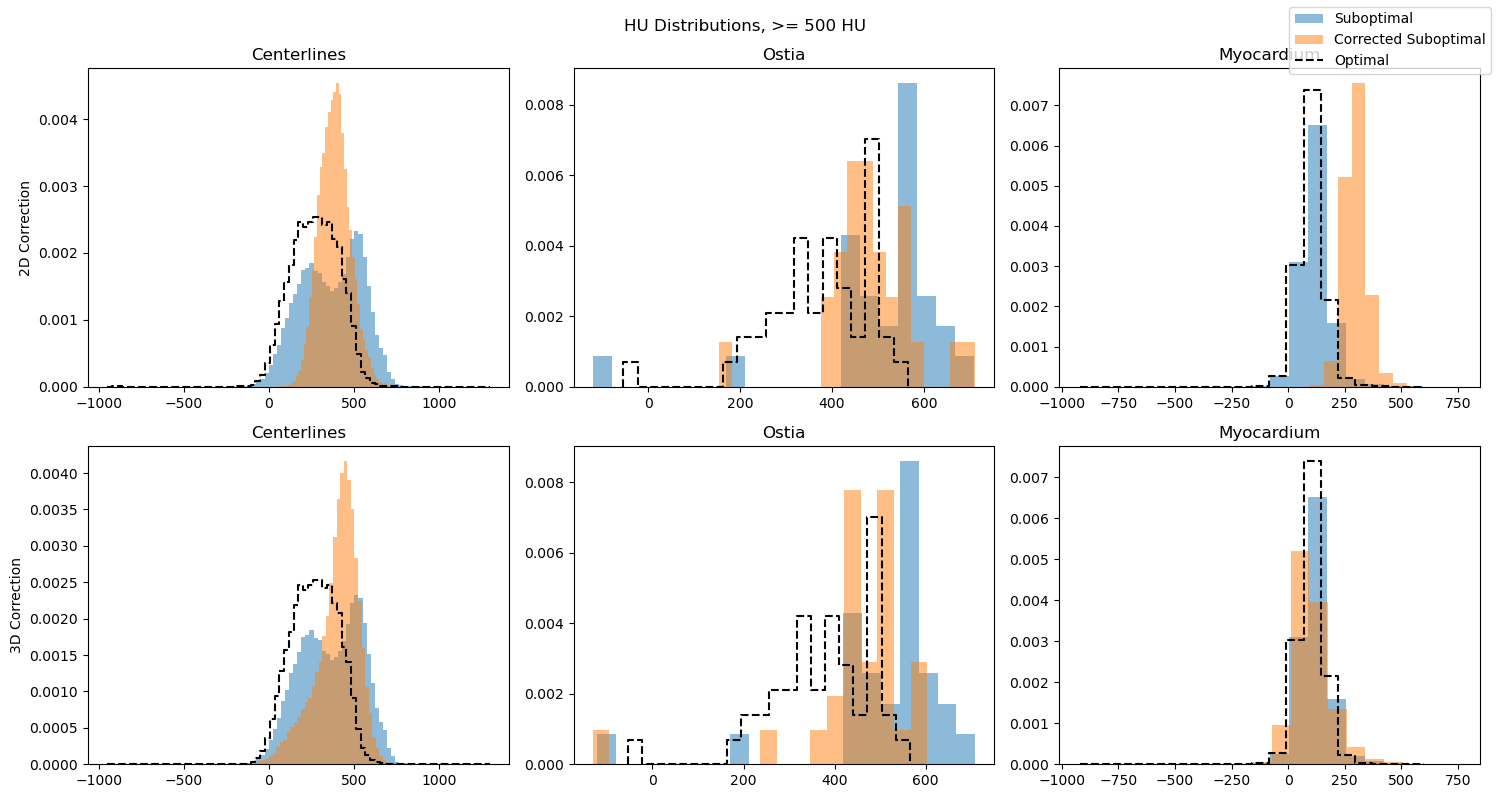

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("HU Distributions, >= 500 HU")

# for ax in axes.flat:
#     ax.set_xlim(-200, 800)
#     ax.set_ylim(0, 0.0075)
#     ax[i, j].set_yticks([])

for i, (raw, corrected) in enumerate(
    [[og_voxels, corrected_voxels_2D], [og_voxels, corrected_voxels_3D]]
):
    for j, tag in enumerate(raw[ScanType.OPT].keys()):
        eval_u.plot_HU_distributions(
            raw[ScanType.HIGH][tag],
            corrected[ScanType.HIGH][tag],
            raw[ScanType.OPT][tag],
            ax=axes[i, j],
            title=tag.capitalize(),
            nbins=80 if j == 0 else 20,
        )

axes[0, 0].set_ylabel("2D Correction")
axes[1, 0].set_ylabel("3D Correction")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()
plt.show()
plt.close(fig)

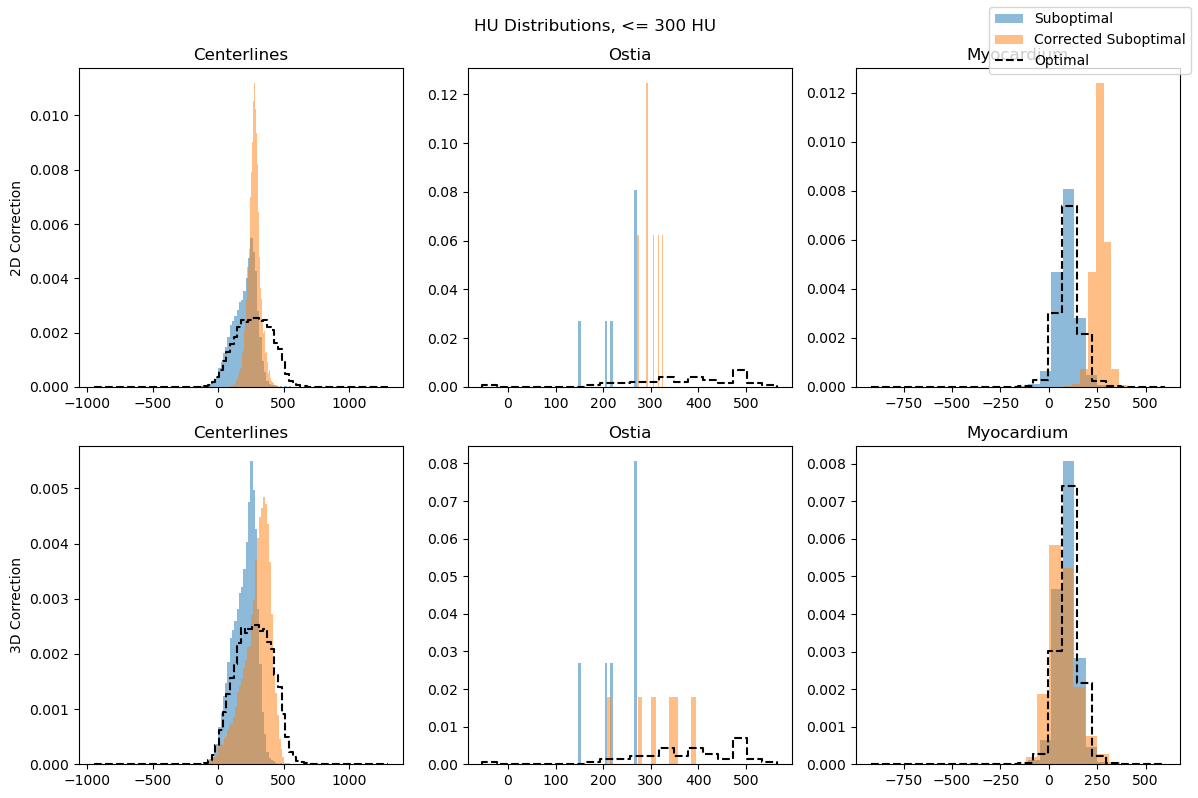

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("HU Distributions, <= 300 HU")

# for ax in axes.flat:
#     ax.set_xlim(-200, 800)
#     ax.set_ylim(0, 0.0075)
#     ax[i, j].set_yticks([])

for i, (raw, corrected) in enumerate(
    [[og_voxels, corrected_voxels_2D], [og_voxels, corrected_voxels_3D]]
):
    for j, tag in enumerate(raw[ScanType.OPT].keys()):
        eval_u.plot_HU_distributions(
            raw[ScanType.LOW][tag],
            corrected[ScanType.LOW][tag],
            raw[ScanType.OPT][tag],
            ax=axes[i, j],
            title=tag.capitalize(),
            nbins=80 if j == 0 else 20,
        )

axes[0, 0].set_ylabel("2D Correction")
axes[1, 0].set_ylabel("3D Correction")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()
plt.show()
plt.close(fig)

In [ ]:
RUN_ID_3D_GEN_MORE = "3u6qq4z6"
model_checkpoint_3D_gen_more = CHECKPOINTS_DIR / RUN_ID_3D / "8000.pt"
print(model_checkpoint_3D_gen_more, model_checkpoint_3D_gen_more.is_file())

/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/blwlllmf/8000.pt True


In [ ]:
_, corrected_voxels_3D_gen_more = eval_u.collect_evaluation_histograms(
    evaluation_paths, corrector_3D
)
torch.cuda.empty_cache()contrast_gan_3D.evalHU_distribution_shift

ScanType.OPT 34
	Total voxels 'centerlines': 123332
	Total voxels 'ostia': 68
ScanType.LOW 5


/home/marco/micromamba/envs/contrast-gan-3D/lib/python3.11/site-packages/patchly/array_like.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


/home/marco/data/ASOCA_Philips/images/ASOCA-034.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-059.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2003_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2019_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_train/ct_train_1019_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

	Total voxels 'centerlines': 13095
	Total voxels 'ostia': 10
ScanType.HIGH 21


/home/marco/data/ASOCA_Philips/images/ASOCA-006.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-011.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-013.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-015.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-017.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-036.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-040.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-043.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-044.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-045.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-050.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/ASOCA_Philips/images/ASOCA-051.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2007_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2013_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2015_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2022_image.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2033_image.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_test/ct_test_2036_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_train/ct_train_1004_image.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_train/ct_train_1018_image.h5:   0%|          | 0/2 [00:00<?, ?it/s]

/home/marco/data/MMWHS/ct_train/ct_train_1020_image.h5:   0%|          | 0/3 [00:00<?, ?it/s]

	Total voxels 'centerlines': 83940
	Total voxels 'ostia': 42


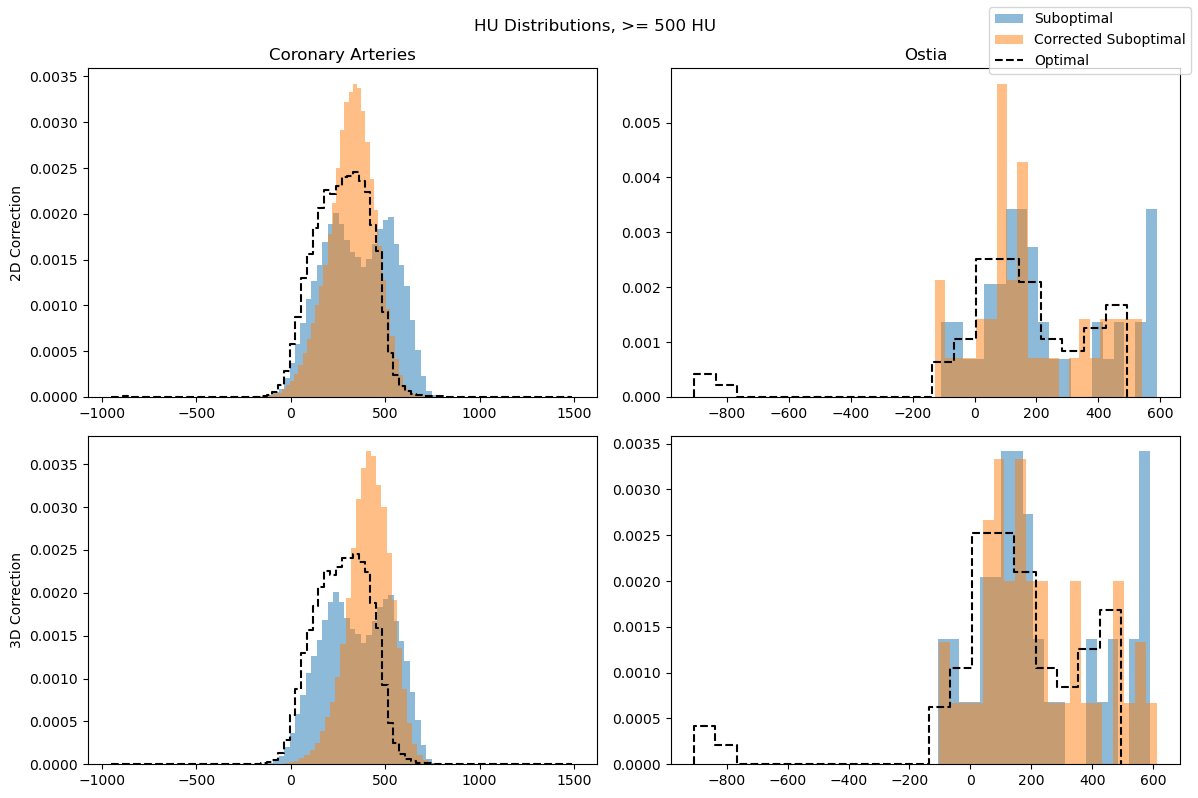

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("HU Distributions, >= 500 HU")

# for ax in axes.flat:
#     ax.set_xlim(-200, 800)
#     ax.set_ylim(0, 0.0075)
#     ax[i, j].set_yticks([])

for i, (raw, corrected) in enumerate(
    [[og_voxels, corrected_voxels_2D], [og_voxels, corrected_voxels_3D_gen_more]]
):
    for j, tag in enumerate(["centerlines", "ostia"]):
        eval_u.plot_HU_distributions(
            raw[ScanType.HIGH][tag],
            corrected[ScanType.HIGH][tag],
            raw[ScanType.OPT][tag],
            ax=axes[i, j],
            nbins=80 if j == 0 else 20,
        )

axes[0, 0].set_title("Coronary Arteries")
axes[0, 1].set_title("Ostia")
axes[0, 0].set_ylabel("2D Correction")
axes[1, 0].set_ylabel("3D Correction")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()
plt.show()
plt.close(fig)

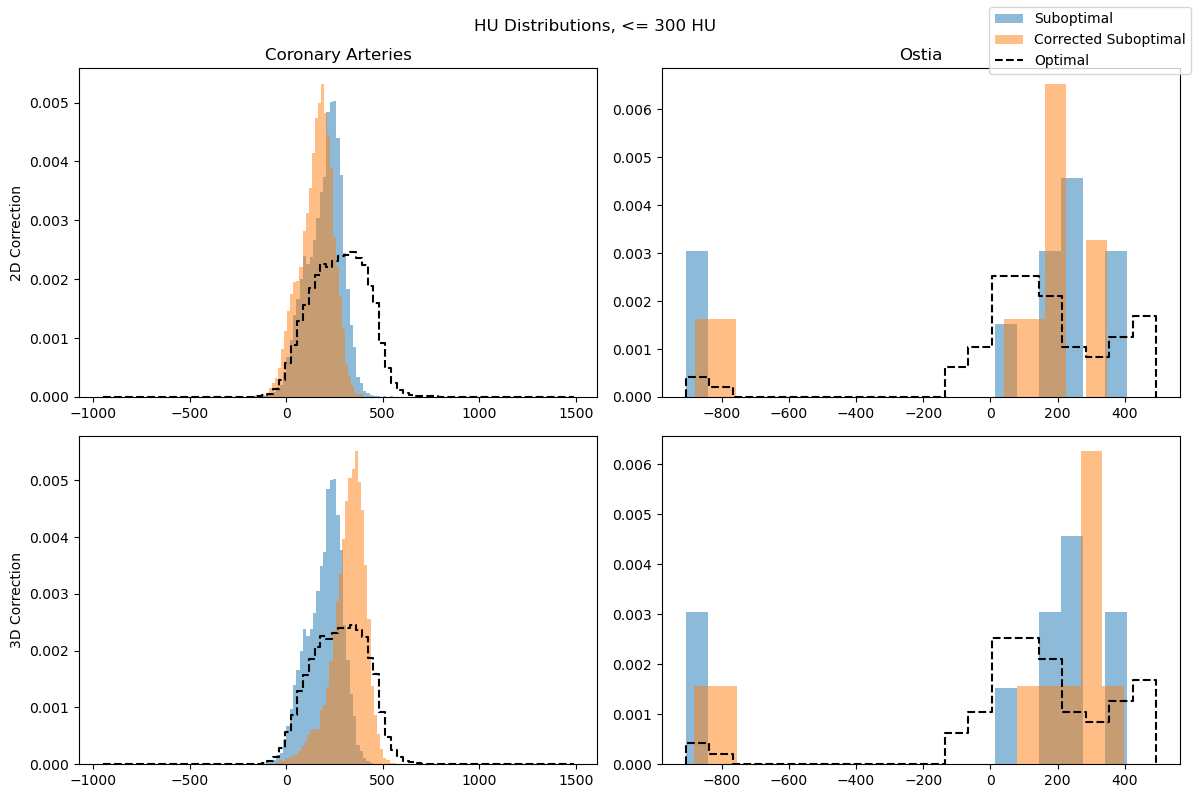

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("HU Distributions, <= 300 HU")

# for ax in axes.flat:
#     ax.set_xlim(-200, 800)
#     ax.set_ylim(0, 0.0075)
#     ax[i, j].set_yticks([])

for i, (raw, corrected) in enumerate(
    [[og_voxels, corrected_voxels_2D], [og_voxels, corrected_voxels_3D_gen_more]]
):
    for j, tag in enumerate(["centerlines", "ostia"]):
        eval_u.plot_HU_distributions(
            raw[ScanType.LOW][tag],
            corrected[ScanType.LOW][tag],
            raw[ScanType.OPT][tag],
            ax=axes[i, j],
            nbins=80 if j == 0 else 20,
        )

axes[0, 0].set_title("Coronary Arteries")
axes[0, 1].set_title("Ostia")
axes[0, 0].set_ylabel("2D Correction")
axes[1, 0].set_ylabel("3D Correction")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()
plt.show()
plt.close(fig)